In [1]:
import dspy
import os
import json
import openai
import shutil

from training_data_loader import STIXDataset

import importlib
import training_data_loader
import hallucination_eval
import graph_aligner, graph_distancer
from hallucination_eval import HalluEvaluator

importlib.reload(training_data_loader)
importlib.reload(graph_aligner)
importlib.reload(graph_distancer)
importlib.reload(hallucination_eval)


# ==============set openAI enviroment=========
# Path to your API key file
key_file_path = "openai_api_key.txt"

# Load the API key from the file
with open(key_file_path, "r") as file:
    openai_api_key = file.read().strip()

# Set the API key as an environment variable
os.environ["OPENAI_API_KEY"] = openai_api_key
openai.api_key = os.environ["OPENAI_API_KEY"]
turbo = dspy.OpenAI(model="gpt-3.5-turbo", max_tokens=2000)
dspy.settings.configure(lm=turbo)
# ==============end of set openAI enviroment=========

In [2]:
database = STIXDataset("data_xu")
train = database.build_trainset()
print(train[0].question)
print(train[0].answer)

A threat actor, named “Adversary Bravo,” was identified in May 2015, known for using phishing attacks to deliver remote access malware, specifically a variant of Poison Ivy. The thread actor conducts spear-phishing campaigns to trick targets into executing malicious payloads, which is a key part of their initial compromise strategy. The Poison Ivy variant they use, named "Poison Ivy Variant d1c6," disguises itself as an executable file such as "resume.pdf" and creates a specific registry key (HKEY_LOCAL_MACHINE\SYSTEM\ControlSet001\Services\WSALG2). Indicators of this malware include specific file hashes (MD5 and SHA-1). This documentation highlights Adversary Bravo's methodical approach to deploying this trojan, underscoring the importance of vigilance against such sophisticated cyber threats.
[{'type': 'malware', 'id': 'malware--d1c6', 'name': 'Poison Ivy Variant d1c6', 'description': 'Variant of Poison Ivy used by Adversary Bravo', 'malware_types': ['trojan'], 'created_by_ref': 'thr

In [3]:
class BasicDFKGBuilder(dspy.Signature):
    """Analyze the scenario to construct a graph in STIX JSON format with several objects."""

    question = dspy.InputField(
        desc="A text description about a cyber incident analysis results."
    )
    answer = dspy.OutputField(
        desc="A list of valid json objects presenting evidence entities and relations between entities. Output must be like '[object1, object2...]'. Each object must have an unique ID."
    )

In [4]:
class Predict(dspy.Module):  # let's define a new module
    def __init__(self):
        super().__init__()

        # here we declare the chain of thought sub-module, so we can later compile it (e.g., teach it a prompt)
        self.generate_answer = dspy.Predict(BasicDFKGBuilder)

    def forward(self, question):
        return self.generate_answer(question=question).answer  # here we use the module


class CoT(dspy.Module):  # let's define a new module
    def __init__(self):
        super().__init__()

        # here we declare the chain of thought sub-module, so we can later compile it (e.g., teach it a prompt)
        self.generate_answer = dspy.ChainOfThought(BasicDFKGBuilder)

    def forward(self, question):
        return self.generate_answer(question=question).answer  # here we use the module

In [5]:
def generator(output_file_path, generator_model, model_name):
    # Delete the folder if it exists
    if os.path.exists(output_file_path):
        shutil.rmtree(output_file_path)
        print(f"Deleted folder: {output_file_path}")
    os.makedirs(output_file_path)

    for index, train_element in enumerate(train):
        file_name=os.path.join(output_file_path, str(index)+"_"+model_name+".json")
        with open(file_name, "w") as json_file:
            # predict and Parse the JSON string
            result = json.loads(generator_model(train_element.question))
            print(result)

            json.dump(result, json_file, indent=4)

In [6]:
output_file_path="output_predict"
generator_model = CoT()
model_namee="predict"
generator(output_file_path, generator_model, model_namee)

Deleted folder: output_predict
[{'type': 'threat-actor', 'id': 'threat-actor--1', 'name': 'Adversary Bravo', 'aliases': ['Adversary Bravo'], 'first_seen': '2015-05'}, {'type': 'malware', 'id': 'malware--1', 'name': 'Poison Ivy Variant d1c6', 'aliases': ['Poison Ivy Variant d1c6'], 'malware_type': 'Remote Access Trojan', 'uses': ['Phishing']}, {'type': 'registry-key', 'id': 'registry-key--1', 'key': 'HKEY_LOCAL_MACHINE\\SYSTEM\\ControlSet001\\Services\\WSALG2', 'created_by': 'Poison Ivy Variant d1c6'}, {'type': 'indicator', 'id': 'indicator--1', 'indicator_type': 'File Hash', 'hashes': {'MD5': '1234567890abcdef', 'SHA-1': 'a1b2c3d4e5f6'}, 'related_to': ['malware--1']}, {'type': 'relationship', 'id': 'relationship--1', 'relationship_type': 'uses', 'source_ref': 'threat-actor--1', 'target_ref': 'malware--1'}, {'type': 'relationship', 'id': 'relationship--2', 'relationship_type': 'created', 'source_ref': 'malware--1', 'target_ref': 'registry-key--1'}, {'type': 'relationship', 'id': 'relati

In [7]:
def test_summary():
    print("============Testing sumamry")
    graph_path1 = "data_xu/0.json"  # Path to your graph JSON file
    graph_path2 = "output_predict/0_predict.json"  # Path to your graph JSON file


    matched_pairs_threshold=0.85
    halluEvaluator = HalluEvaluator(
        graph_pathA=graph_path1,
        graph_pathB=graph_path2,
        matched_pairs_threshold=matched_pairs_threshold,
    )


    print(halluEvaluator.summary(threshold=0.85))
    halluEvaluator.graphDistancer.visualize_graphs()

============Testing sumamry


i:\conda_envs\dspy_dfkg\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[{'type': 'malware', 'id': '10000', 'name': 'Poison Ivy Variant d1c6', 'description': 'Variant of Poison Ivy used by Adversary Bravo', 'malware_types': ['trojan'], 'created_by_ref': '10004'}, {'type': 'indicator', 'id': '10001', 'indicator_types': ['file-hash-md5'], 'pattern': "[file:hashes.md5 = 'd1c6_hash_md5']", 'valid_from': '2015-05-01T00:00:00Z'}, {'type': 'indicator', 'id': '10002', 'indicator_types': ['file-hash-sha1'], 'pattern': "[file:hashes.sha1 = 'd1c6_hash_sha1']", 'valid_from': '2015-05-01T00:00:00Z'}, {'type': 'campaign', 'id': '10003', 'name': 'Adversary Bravo Phishing Campaign', 'description': 'Spear phishing campaigns by Adversary Bravo to deliver Poison Ivy Variant d1c6', 'created_by_ref': '10004'}, {'type': 'threat-actor', 'id': '10004', 'name': 'Adversary Bravo', 'description': 'Threat actor known for using phishing attacks to deliver malware', 'sophistication': 'high'}, {'type': 'tool', 'id': '10005', 'name': 'Poison Ivy', 'description': 'Remote access malware us

i:\conda_envs\dspy_dfkg\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Strat building networkx graph!
Strat building networkx graph!
(7, 13, 53.84615384615385, 3, 5, 60.0, 0, 2, 0.0)


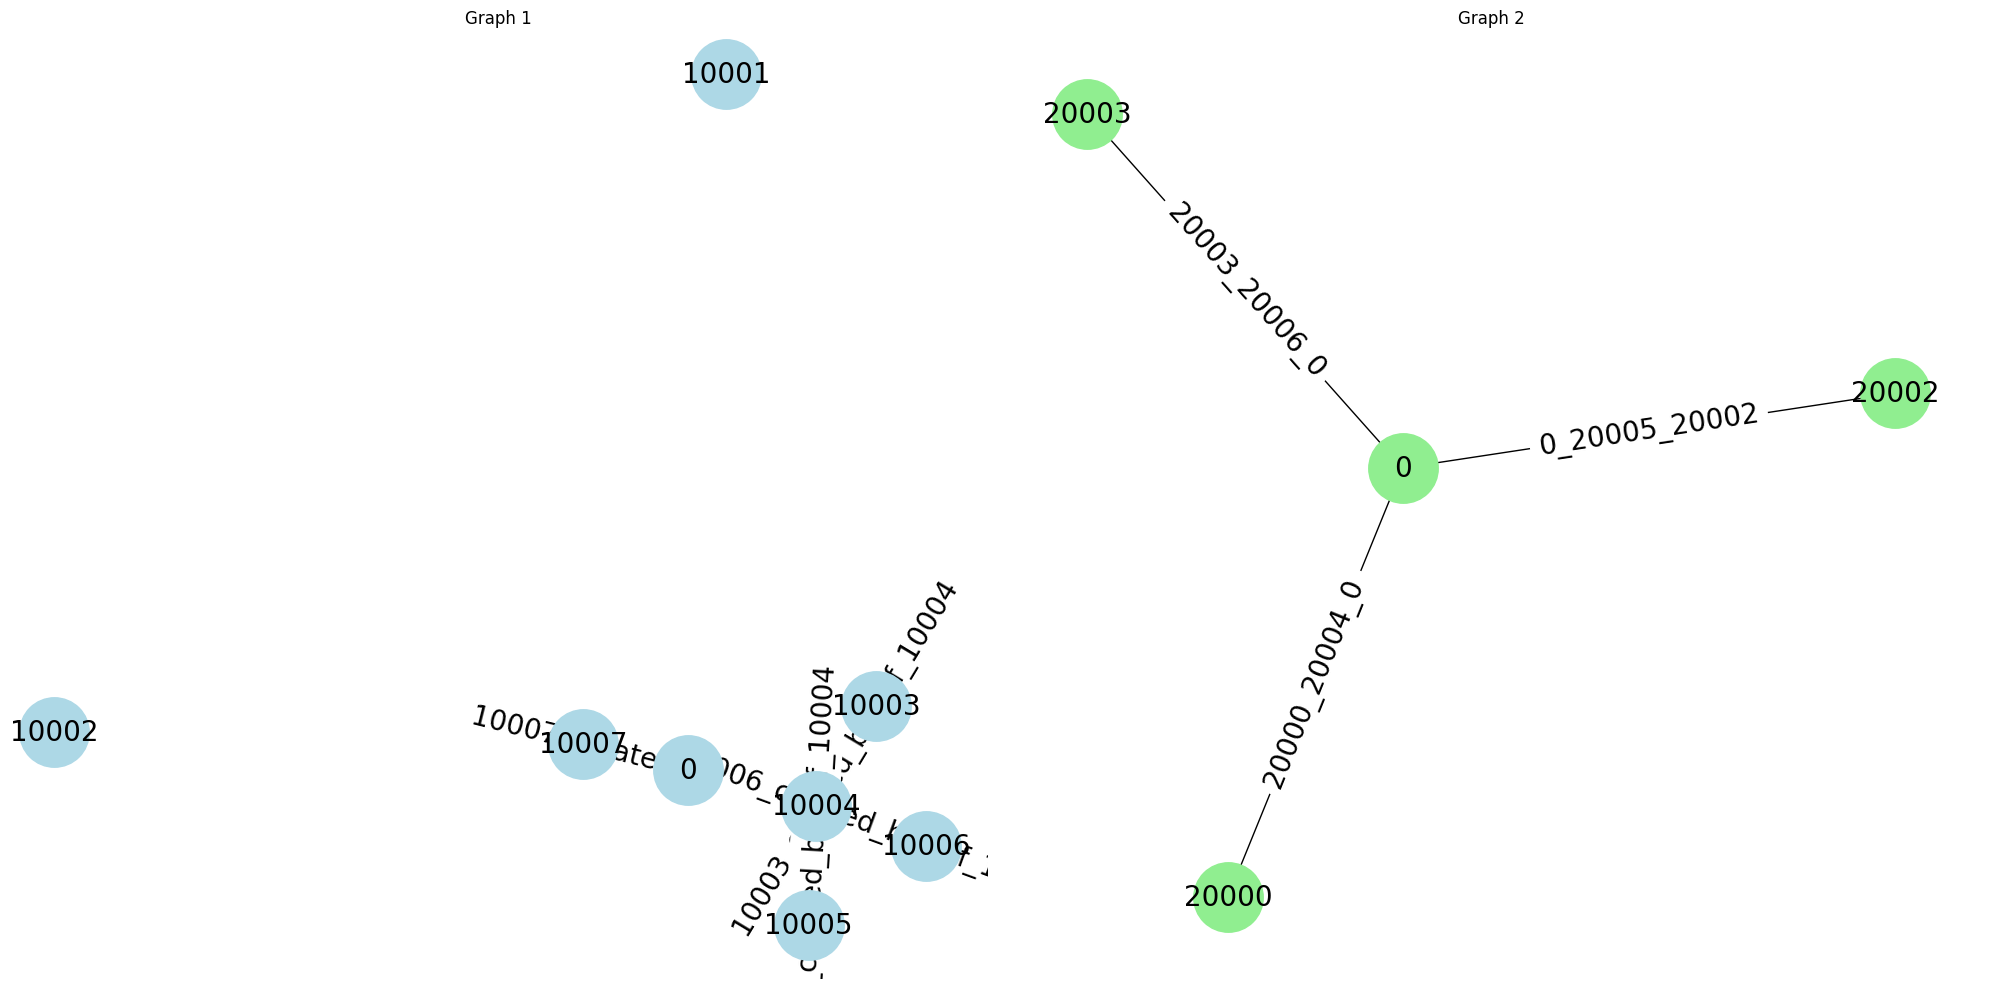

In [8]:
test_summary()